In [1]:
# Import the required libraries.
import os
import cv2
#import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

#from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

import os
os.environ['PYTHONHASHSEED'] = '0'
os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [2]:
tf.keras.backend.clear_session()
seed_constant = 27
np.random.seed(seed_constant)
tf.random.set_seed(seed_constant)
random.seed(seed_constant)
tf.keras.utils.set_random_seed(seed_constant)

In [3]:
# Create a Matplotlib figure and specify the size of the figure.
plt.figure(figsize = (20, 20))

# Get the names of all classes/categories in UCF50.
TRAIN_DIR = r'train'
VAL_DIR = r'val'
TEST_DIR = r'test'
all_classes_names = sorted(os.listdir(TRAIN_DIR))
print(all_classes_names)


['10outfinal', '1outfinal', '2outfinal', '3outfinal', '4outfinal', '5outfinal', '6outfinal', '7outfinal', '8outfinal', '9outfinal']


<Figure size 2000x2000 with 0 Axes>

In [4]:
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 80, 80

# Specify the directory containing the UCF50 dataset. 
#DATASET_DIR = "/newdatasetMediapipe/kata/"

# Specify the list containing the names of the classes used for training. Feel free to choose any set of classes.
CLASSES_LIST =all_classes_names
#CLASSES_LIST = ['2 Tolong', '7 permisi', '1 Maaf']

In [5]:
SEQUENCE_LENGTH = 30#getAverageSequenceLength()
print(SEQUENCE_LENGTH)

30


In [6]:
def getDatafromNpz(file):
    return file['data'],file['label']
dtrain = np.load('feature_train.npz')
dval = np.load('feature_val.npz')
dtest = np.load('feature_test.npz')

features_train,labels_train = getDatafromNpz(dtrain)
features_test,labels_test = getDatafromNpz(dtest)
features_val,labels_val = getDatafromNpz(dval)

In [7]:
def create_convlstm_model():
    '''
    This function will construct the required convlstm model.
    Returns:
        model: It is the required constructed convlstm model.
    '''

    # We will use a Sequential model for model construction
    model = Sequential()

    # Define the Model Architecture.
    ########################################################################################################################
    
    model.add(ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh',data_format = "channels_last", dropout=0.3,
                          return_sequences=True, input_shape = (SEQUENCE_LENGTH,
                                                                                      IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    
    model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same', data_format='channels_last'))
    #model.add(TimeDistributed(Dropout(0.3)))
    
    model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last", dropout=0.3,
                          return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same', data_format='channels_last'))
    #model.add(TimeDistributed(Dropout(0.3)))
    
    #model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
    #                     dropout=0.2, return_sequences=True))
    
    #model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    #model.add(TimeDistributed(Dropout(0.2)))
    
    
    model.add(Flatten()) 
    
    model.add(Dense(len(CLASSES_LIST), activation = "softmax"))
    
    ########################################################################################################################
     
    # Display the models summary.
    model.summary()
    
    # Return the constructed convlstm model.
    return model

In [ ]:
def create_convlstm_model():
    #tf.keras.backend.clear_session()
    '''
    This function will construct the required LRCN model.
    Returns:
        model: It is the required constructed LRCN model.
    '''
    IMAGE_SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH) + (3,)
    base_model = tf.keras.applications.MobileNetV2(weights='imagenet',  include_top=False)
    #base_model.trainable = False
    # the 4 last layers (my own choice, up to you)
    for layer in base_model.layers:
        layer.trainable = False
    
    inputs = Input(shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3))
    x = TimeDistributed(base_model)(inputs)
    #x = TimeDistributed(Dense(192))(x)

    #the ouput of the model is [1, 1, 2048], need to squeeze
    #x = Lambda(lambda x: tf.squeeze(tf.squeeze(x,2),2))(x)
    x = TimeDistributed(Flatten())(x)
    x = Bidirectional(LSTM(16, return_sequences=False))(x)
    #x = BatchNormalization()(x)
    """x = LSTM(100, activation='relu', return_sequences=True)(x)
    x = Dense(100, activation = 'relu')(x)
    x = Dropout(0.25)(x)
    x = LSTM(100, activation='relu', return_sequences=False)(x)
    x = Dense(50, activation = 'relu')(x)"""
    
    outputs = Dense(len(CLASSES_LIST), activation = 'softmax')(x)
    model = tf.keras.Model(inputs, outputs)

    # Display the models summary.
    model.summary()
    
    # Return the constructed LRCN model.
    return model

In [ ]:
#The best
def create_convlstm_model():
    '''
    This function will construct the required LRCN model.
    Returns:
        model: It is the required constructed LRCN model.
    '''

    # We will use a Sequential model for model construction.
    model = Sequential()
    
    # Define the Model Architecture.
    ########################################################################################################################

    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    model.add(TimeDistributed(MaxPooling2D((2, 2)))) 
    model.add(Dropout(0.3))
    
    model.add(TimeDistributed(Conv2D(
        32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(Dropout(0.3))
    
    #model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    #model.add(TimeDistributed(MaxPooling2D((2, 2))))
    #model.add(Dropout(0.3))
    
    #model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    #model.add(TimeDistributed(MaxPooling2D((2, 2))))
    #model.add(TimeDistributed(Dropout(0.25)))
                                      
    model.add(TimeDistributed(Flatten()))#GOAP
    #model.add(Dropout(0.4))                               
    model.add(LSTM(64, return_sequences=False))#32
    #model.add(BatchNormalization())
    model.add(Dropout(0.3))
                                      
    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))

    ########################################################################################################################

    # Display the models summary.
    model.summary()
    
    # Return the constructed LRCN model.
    return model

In [8]:
# Construct the required convlstm model.
convlstm_model = create_convlstm_model()

# Display the success message. 
print("Model Created Successfully!")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 30, 78, 78, 8)     3200      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 15, 39, 39, 8)    0         
 )                                                               
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 15, 37, 37, 16)    13888     
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 8, 19, 19, 16)    0         
 3D)                                                             
                                                                 
 flatten (Flatten)           (None, 46208)             0         
                                                                 
 dense (Dense)               (None, 10)                4

In [9]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import Callback

from timeit import default_timer as timer

class TimingCallback(Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)

cb = TimingCallback()

model_ckpt = ModelCheckpoint('MyNet.h5',monitor='val_accuracy', verbose=1,save_best_only=True )
# Compile the model and specify loss function, optimizer and metrics values to the model
adam=tf.keras.optimizers.Adam(learning_rate=0.0005)
convlstm_model.compile(loss = 'categorical_crossentropy',optimizer=adam, metrics = ["accuracy"])
#tf.keras.optimizers.Adam(lr=0.0005)
# Start training the model.
convlstm_model_training_history = convlstm_model.fit(x = features_train, y = labels_train, epochs = 100, batch_size = 4,
                                                     validation_data=(features_val, labels_val),
                                                     callbacks = [cb,model_ckpt])
                                                     #callbacks = [TerminateOnBaseline(monitor='val_accuracy', baseline=0.96)])

Epoch 1/100
480/480 [==============================] - ETA: 0s - loss: 1.8716 - accuracy: 0.3271
Epoch 1: val_accuracy improved from -inf to 0.49583, saving model to MyNet.h5
480/480 [==============================] - 89s 166ms/step - loss: 1.8716 - accuracy: 0.3271 - val_loss: 1.3406 - val_accuracy: 0.4958
Epoch 2/100
480/480 [==============================] - ETA: 0s - loss: 0.7894 - accuracy: 0.7573
Epoch 2: val_accuracy improved from 0.49583 to 0.76250, saving model to MyNet.h5
480/480 [==============================] - 79s 166ms/step - loss: 0.7894 - accuracy: 0.7573 - val_loss: 0.7599 - val_accuracy: 0.7625
Epoch 3/100
480/480 [==============================] - ETA: 0s - loss: 0.4165 - accuracy: 0.8651
Epoch 3: val_accuracy improved from 0.76250 to 0.85000, saving model to MyNet.h5
480/480 [==============================] - 82s 171ms/step - loss: 0.4165 - accuracy: 0.8651 - val_loss: 0.5075 - val_accuracy: 0.8500
Epoch 4/100
480/480 [==============================] - ETA: 0s - lo

Epoch 29/100
480/480 [==============================] - ETA: 0s - loss: 0.0033 - accuracy: 0.9995
Epoch 29: val_accuracy did not improve from 0.92917
480/480 [==============================] - 80s 166ms/step - loss: 0.0033 - accuracy: 0.9995 - val_loss: 0.4738 - val_accuracy: 0.9250
Epoch 30/100
480/480 [==============================] - ETA: 0s - loss: 0.0086 - accuracy: 0.9964
Epoch 30: val_accuracy did not improve from 0.92917
480/480 [==============================] - 79s 164ms/step - loss: 0.0086 - accuracy: 0.9964 - val_loss: 0.4842 - val_accuracy: 0.8958
Epoch 31/100
480/480 [==============================] - ETA: 0s - loss: 0.0499 - accuracy: 0.9859
Epoch 31: val_accuracy did not improve from 0.92917
480/480 [==============================] - 79s 165ms/step - loss: 0.0499 - accuracy: 0.9859 - val_loss: 0.5770 - val_accuracy: 0.8542
Epoch 32/100
480/480 [==============================] - ETA: 0s - loss: 0.0380 - accuracy: 0.9911
Epoch 32: val_accuracy improved from 0.92917 to 0.

480/480 [==============================] - ETA: 0s - loss: 7.1697e-05 - accuracy: 1.0000
Epoch 57: val_accuracy did not improve from 0.94167
480/480 [==============================] - 80s 167ms/step - loss: 7.1697e-05 - accuracy: 1.0000 - val_loss: 0.5363 - val_accuracy: 0.9042
Epoch 58/100
480/480 [==============================] - ETA: 0s - loss: 0.0847 - accuracy: 0.9786
Epoch 58: val_accuracy did not improve from 0.94167
480/480 [==============================] - 80s 166ms/step - loss: 0.0847 - accuracy: 0.9786 - val_loss: 0.4471 - val_accuracy: 0.9250
Epoch 59/100
480/480 [==============================] - ETA: 0s - loss: 0.0059 - accuracy: 0.9974
Epoch 59: val_accuracy did not improve from 0.94167
480/480 [==============================] - 82s 171ms/step - loss: 0.0059 - accuracy: 0.9974 - val_loss: 0.4317 - val_accuracy: 0.9167
Epoch 60/100
480/480 [==============================] - ETA: 0s - loss: 4.8430e-04 - accuracy: 1.0000
Epoch 60: val_accuracy did not improve from 0.94167

480/480 [==============================] - 80s 167ms/step - loss: 1.1525e-04 - accuracy: 1.0000 - val_loss: 0.5020 - val_accuracy: 0.9208
Epoch 86/100
480/480 [==============================] - ETA: 0s - loss: 1.3725e-04 - accuracy: 1.0000
Epoch 86: val_accuracy did not improve from 0.94167
480/480 [==============================] - 79s 165ms/step - loss: 1.3725e-04 - accuracy: 1.0000 - val_loss: 0.7532 - val_accuracy: 0.9083
Epoch 87/100
480/480 [==============================] - ETA: 0s - loss: 0.0636 - accuracy: 0.9833
Epoch 87: val_accuracy did not improve from 0.94167
480/480 [==============================] - 83s 172ms/step - loss: 0.0636 - accuracy: 0.9833 - val_loss: 0.6053 - val_accuracy: 0.9000
Epoch 88/100
480/480 [==============================] - ETA: 0s - loss: 0.0321 - accuracy: 0.9906
Epoch 88: val_accuracy did not improve from 0.94167
480/480 [==============================] - 82s 170ms/step - loss: 0.0321 - accuracy: 0.9906 - val_loss: 0.4148 - val_accuracy: 0.9333
Ep

In [10]:
print(cb.logs)
print(sum(cb.logs))
np.save('my_history.npy',convlstm_model_training_history.history)

[88.9216481, 79.43365599999998, 82.20608339999998, 81.92844330000003, 81.4647574, 80.12106650000004, 81.49965929999996, 79.44564030000004, 80.54326500000002, 81.17178750000005, 79.54663740000001, 80.61907629999996, 78.19297970000002, 80.17873940000004, 79.32634600000006, 80.48970480000003, 79.52324369999997, 77.78759419999983, 79.11427149999986, 79.52211710000006, 79.28243369999996, 79.23278400000004, 76.65813260000004, 79.26401889999988, 79.26027580000004, 78.53609140000003, 77.92566850000003, 78.6241015999999, 79.5182676999998, 78.86166169999979, 79.18438730000025, 79.76961130000018, 79.8772672, 78.72697110000036, 78.95712839999987, 79.11768559999973, 79.45842739999989, 78.31720320000022, 78.72822700000006, 79.29048269999976, 78.7169498000003, 78.02665859999979, 78.53771370000004, 79.34341059999997, 77.38145859999986, 77.80069110000022, 80.19111879999991, 79.75369280000041, 78.70316720000028, 78.08680580000009, 79.32067340000003, 80.0516733000004, 79.77055660000042, 79.54810130000078

In [11]:
history=np.load('my_history.npy',allow_pickle='TRUE').item()

In [12]:
convlstm_model_training_history = history

In [13]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation 
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''
    
    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history[metric_name_1]
    metric_value_2 = model_training_history[metric_name_2]
    
    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()
    
    plt.savefig("output"+metric_name_1+".jpg")

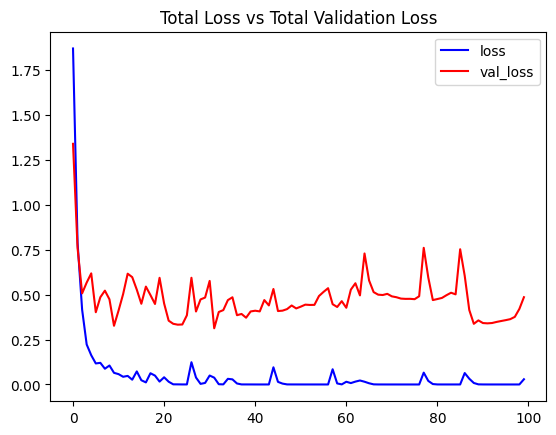

In [14]:
# Visualize the training and validation loss metrices.
plot_metric(convlstm_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

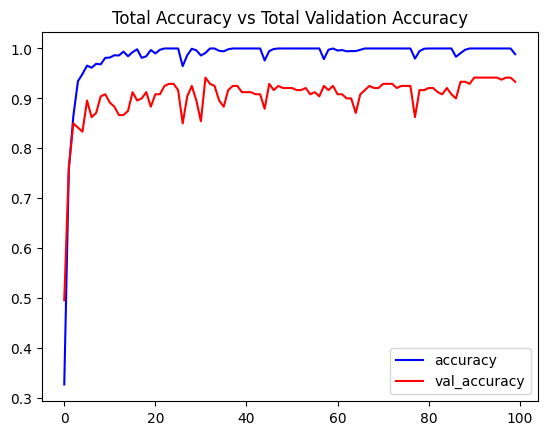

In [15]:
# Visualize the training and validation accuracy metrices.
plot_metric(convlstm_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy') 

In [ ]:
# Evaluate the trained model.
from keras.models import load_model
convlstm_model = load_model("MyNet.h5")
model_evaluation_history = convlstm_model.evaluate(features_test, labels_test)


In [ ]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'convlstm_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

# Save your Model.
convlstm_model.save(model_file_name)

In [ ]:
predict_x=convlstm_model.predict(features_test) 
rounded_predictions=np.argmax(predict_x,axis=1)

print(rounded_predictions[1])

rounded_labels=np.argmax(labels_test, axis=1)
print(rounded_labels[1])
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(rounded_labels, rounded_predictions)
print(cm)


In [ ]:
from sklearn.metrics import classification_report
# predict 
predictions = convlstm_model.predict(features_test)#, batch_size = 4)
pred = np.argmax(predictions, axis=1)
# label
rounded_labels=np.argmax(labels_test, axis=1)

print(classification_report(rounded_labels, pred))
# precission “Berapa persen mahasiswa yang benar DO dari keseluruhan mahasiswa yang diprediksi DO?”
# recall "Berapa persen mahasiswa yang diprediksi DO dibandingkan keseluruhan mahasiswa yang sebenarnya DO?"